In [ ]:
# %%
import os

cache_dir = '/scratch/hakeem.at/Queryable-Shared-Reference-Repository/notebooks/pretrained_models'

os.environ['HF_HOME'] = cache_dir
os.environ['TRANSFORMERS_CACHE'] = cache_dir
os.environ['HUGGINGFACE_HUB_CACHE'] = cache_dir

import warnings
import logging
import os
import sys
from contextlib import contextmanager

warnings.filterwarnings("ignore")
os.environ['PYTHONWARNINGS'] = 'ignore'

logging.getLogger("docling").setLevel(logging.ERROR)
logging.getLogger("docling.backend").setLevel(logging.ERROR)
logging.getLogger("docling.datamodel").setLevel(logging.ERROR)
logging.getLogger("docling_parse").setLevel(logging.ERROR)
logging.getLogger("PIL").setLevel(logging.ERROR)
logging.getLogger("pdfplumber").setLevel(logging.ERROR)
logging.getLogger("pdfminer").setLevel(logging.ERROR)

for logger_name in logging.Logger.manager.loggerDict.keys():
    if 'docling' in logger_name.lower() or 'pdf' in logger_name.lower():
        logging.getLogger(logger_name).setLevel(logging.CRITICAL)

@contextmanager
def suppress_stdout_stderr():
    """Suppress all output to stdout and stderr."""
    null_file = open(os.devnull, 'w')
    old_stdout = sys.stdout
    old_stderr = sys.stderr
    sys.stdout = null_file
    sys.stderr = null_file
    try:
        yield
    finally:
        sys.stdout = old_stdout
        sys.stderr = old_stderr
        null_file.close()

# %%
import os
import time
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import json
import random
from tqdm.auto import tqdm

from langchain.embeddings.base import Embeddings
from langchain_community.vectorstores import FAISS

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer, CrossEncoder

# %%
from docling_core.types.doc.document import DoclingDocument
from docling.chunking import HybridChunker
from docling_core.transforms.chunker.tokenizer.huggingface import HuggingFaceTokenizer

# %%
import torch
import gc

In [ ]:
def clear_gpu(*items):
    for item in items:
        del item
    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.synchronize()

# %%
seed = 42
random.seed(seed)

# %%
class EmbeddingGemmaEmbeddings(Embeddings):
    def __init__(self, model_id='google/embeddinggemma-300m', device="cuda", batch_size=32, max_seq_length=512):
        self.model = SentenceTransformer(model_id, device=device)
        self.model.max_seq_length = max_seq_length
        self.batch_size = batch_size
        self.tokenizer = self.model.tokenizer
    
    def embed_documents(self, texts, prompt_name="Retrieval-document"):
        embeddings = self.model.encode(
            texts,
            prompt_name=prompt_name,
            batch_size=self.batch_size,
            convert_to_tensor=True
        )
        return embeddings.cpu().numpy().tolist()
    
    def embed_query(self, text):
        embedding = self.model.encode(
            [text],
            prompt_name="Retrieval-query",
            convert_to_tensor=True
        )
        return embedding.cpu().numpy().tolist()[0]

In [ ]:
class GemmaReranker:
    """Reranker using Gemma embeddings with Reranking prompt"""
    def __init__(self, model_id='google/embeddinggemma-300m', device="cuda", batch_size=2048, max_seq_length=2048):
        self.model = SentenceTransformer(model_id, device=device)
        self.model.max_seq_length = max_seq_length
        self.batch_size = batch_size
    
    def rerank(self, query, documents, top_k=5):
        """
        Rerank documents using Gemma model's similarity method with Reranking prompt
        Returns: List of (document, score) tuples sorted by relevance
        """
        query_embedding = self.model.encode(
            [query],
            prompt_name="Reranking",
            convert_to_tensor=True
        )
        
        doc_embeddings = self.model.encode(
            documents,
            prompt_name="Reranking",
            batch_size=self.batch_size,
            convert_to_tensor=True
        )
        
        similarities = self.model.similarity(query_embedding, doc_embeddings)
        scores = similarities[0].cpu().numpy()
        
        ranked_indices = np.argsort(scores)[::-1][:top_k]
        
        reranked_docs = [(documents[idx], float(scores[idx])) for idx in ranked_indices]
        return reranked_docs

# %%
class JinaReranker:
    """Reranker using Jina reranker v2 model"""
    def __init__(self, model_id='jinaai/jina-reranker-v2-base-multilingual', device="cuda"):
        self.model = CrossEncoder(
            model_id,
            automodel_args={"torch_dtype": "auto"},
            trust_remote_code=True,
            device=device
        )
    
    def rerank(self, query, documents, top_k=5):
        """
        Rerank documents using Jina cross-encoder
        Returns: List of (document, score) tuples sorted by relevance
        """
        pairs = [[query, doc] for doc in documents]
        
        scores = self.model.predict(pairs, convert_to_tensor=False)
        
        ranked_indices = np.argsort(scores)[::-1][:top_k]
        
        reranked_docs = [(documents[idx], float(scores[idx])) for idx in ranked_indices]
        return reranked_docs

In [ ]:
# %%
eval_qa_dataset_path = "eval_qa_data.json"

with open(eval_qa_dataset_path, "r") as f:
    eval_qa_dataset = json.load(f)

# %%
filtered_eval_qa_dataset = []
count = 0
for qa in eval_qa_dataset:
    if set(qa["question"].lower().strip().split()) and set(qa["excerpt"].lower().strip().split()):
        filtered_eval_qa_dataset.append(qa)
    else:
        count += 1
print(f"Found {count} empty datapoints")

# %%
ground_truth_docs = []
for qa in filtered_eval_qa_dataset:
    excerpt = set(qa["excerpt"].lower().strip().split())
    if excerpt:
        ground_truth_docs.append(excerpt)

queries = [qa["question"] for qa in filtered_eval_qa_dataset]

# %%
def retrieval_metrics(retrieved_docs_list, ground_truth_docs, hit_rate_threshold=0.5, mrr_threshold=0.3):
    ious = []
    precisions = []
    recalls = []
    hits = []
    mrrs = []
    flattened_retrieved_docs = []
    
    for retrieved_docs in retrieved_docs_list:
        flattened_retrieved_doc = set()
        for retrieved_doc in retrieved_docs:
            doc = set(retrieved_doc.lower().strip().split())
            flattened_retrieved_doc.update(doc)
        flattened_retrieved_docs.append(flattened_retrieved_doc)

    for retrieved_docs, retrieved_doc, ground_truth_doc in zip(retrieved_docs_list, flattened_retrieved_docs, ground_truth_docs):
        intersection = len(retrieved_doc & ground_truth_doc)
        union = len(retrieved_doc | ground_truth_doc)
        iou = intersection / union if union > 0 else 0
        precision = intersection / len(retrieved_doc) if len(retrieved_doc) > 0 else 0
        recall = intersection / len(ground_truth_doc) if len(ground_truth_doc) > 0 else 0

        hit = 0
        if recall >= hit_rate_threshold:
            hit = 1
        
        mrr = 0
        for rank, doc in enumerate(retrieved_docs, start=1):
            doc = set(doc.lower().strip().split())
            overlap = len(doc & ground_truth_doc) / len(ground_truth_doc) if len(ground_truth_doc) > 0 else 0
            if overlap >= mrr_threshold:
                mrr = 1.0 / rank
                break
        
        ious.append(iou)
        precisions.append(precision)
        recalls.append(recall)
        hits.append(hit)
        mrrs.append(mrr)
    
    return {
        'recall_mean': np.mean(recalls),
        'recall_std': np.std(recalls),
        'precision_mean': np.mean(precisions),
        'precision_std': np.std(precisions),
        'iou_mean': np.mean(ious),
        'iou_std': np.std(ious),
        'hit_rate': np.mean(hits),
        'mrr_mean': np.mean(mrrs),
        'mrr_std': np.std(mrrs)
    }

# %%
output_file = "docling_processed_text.jsonl"
loaded_docs = []
print("Loading preprocessed documents...")
with open(output_file, "r") as f:
    for line in tqdm(f):
        doc = json.loads(line)
        doc = DoclingDocument.model_validate(doc)
        loaded_docs.append(doc)

print(f"Loaded {len(loaded_docs)} documents")

In [ ]:

# %%
print("\n=== Initializing Gemma Embeddings (2048 tokens) ===")
embedding_model = EmbeddingGemmaEmbeddings(max_seq_length=2048)
tokenizer = HuggingFaceTokenizer(
    tokenizer=embedding_model.tokenizer,
    max_tokens=2048
)

# %%
print("\n=== Chunking Documents (Hybrid Strategy) ===")
chunker = HybridChunker(merge_peers=True, tokenizer=tokenizer)
chunked_datas = []
metadatas = []

start_time = time.time()
for doc_idx, doc in enumerate(tqdm(loaded_docs, desc="Chunking")):
    try:
        chunks = chunker.chunk(dl_doc=doc)
        chunks = [chunker.contextualize(chunk) for chunk in chunks]
        chunked_datas.extend(chunks)
        metadatas.extend([{"chunk_id": f"{doc_idx}_hybrid_{chunk_idx}", "doc_idx": doc_idx} 
                         for chunk_idx in range(len(chunks))])
    except Exception as e:
        print(f"Chunking error for doc {doc_idx}: {str(e)}")

chunking_time = time.time() - start_time
print(f"⏱️ Chunking: {chunking_time:.2f}s | Chunks: {len(chunked_datas)}")

# %%
print("\n=== Creating FAISS Index ===")
start_time = time.time()
vector_store = FAISS.from_texts(chunked_datas, embedding_model, metadatas=metadatas)
embedding_time = time.time() - start_time
print(f"⏱️ Embedding + FAISS indexing: {embedding_time:.2f}s")

# %%
print("\n=== Encoding Queries ===")
start_time = time.time()
query_embeddings = embedding_model.embed_documents(queries, prompt_name="Retrieval-query")
query_encoding_time = time.time() - start_time
print(f"⏱️ Query encoding: {query_encoding_time:.2f}s")

# %%
INITIAL_K = 30
FINAL_K = 5   

print(f"\n=== Initial Retrieval (k={INITIAL_K}) ===")
initial_retrieved_docs = []
initial_retrieval_time_start = time.time()

for query_idx, query_embedding in enumerate(tqdm(query_embeddings, desc="Initial retrieval")):
    retrieved_doc = vector_store.similarity_search_by_vector(query_embedding, k=INITIAL_K)
    retrieved_doc_texts = [doc.page_content for doc in retrieved_doc]
    initial_retrieved_docs.append(retrieved_doc_texts)

initial_retrieval_time = time.time() - initial_retrieval_time_start
print(f"⏱️ Initial retrieval: {initial_retrieval_time:.2f}s")

In [ ]:
print("\n=== Baseline: No Reranking (Top 5) ===")
baseline_retrieved = [docs[:FINAL_K] for docs in initial_retrieved_docs]

start_time = time.time()
baseline_metrics = retrieval_metrics(baseline_retrieved, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("\nBaseline Metrics:")
for metric, value in baseline_metrics.items():
    print(f"  {metric}: {value:.4f}")

for query_idx, docs in enumerate(baseline_retrieved):
    filtered_eval_qa_dataset[query_idx]["retrieved_docs_gemma2048_hybrid_baseline"] = docs

In [ ]:

# %%
print("\n=== Reranking Method 1: Gemma Embeddings (Reranking prompt) ===")
gemma_reranker = GemmaReranker(max_seq_length=2048)

gemma_reranked_docs = []
gemma_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="Gemma reranking")):
    initial_docs = initial_retrieved_docs[query_idx]
    reranked = gemma_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gemma_reranked_docs.append(reranked_docs)

gemma_reranking_time = time.time() - gemma_reranking_time_start
print(f"⏱️ Gemma reranking: {gemma_reranking_time:.2f}s")

start_time = time.time()
gemma_metrics = retrieval_metrics(gemma_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("\nGemma Reranking Metrics:")
for metric, value in gemma_metrics.items():
    print(f"  {metric}: {value:.4f}")

for query_idx, docs in enumerate(gemma_reranked_docs):
    filtered_eval_qa_dataset[query_idx]["retrieved_docs_gemma2048_hybrid_gemma_rerank"] = docs

clear_gpu(gemma_reranker)

In [ ]:
print("\n=== Reranking Method 2: Jina Reranker v2 ===")
jina_reranker = JinaReranker()

jina_reranked_docs = []
jina_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="Jina reranking")):
    initial_docs = initial_retrieved_docs[query_idx]
    reranked = jina_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    jina_reranked_docs.append(reranked_docs)

jina_reranking_time = time.time() - jina_reranking_time_start
print(f"⏱️ Jina reranking: {jina_reranking_time:.2f}s")

start_time = time.time()
jina_metrics = retrieval_metrics(jina_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"⏱️ Metrics computation: {metrics_time:.2f}s")
print("\nJina Reranking Metrics:")
for metric, value in jina_metrics.items():
    print(f"  {metric}: {value:.4f}")

for query_idx, docs in enumerate(jina_reranked_docs):
    filtered_eval_qa_dataset[query_idx]["retrieved_docs_gemma2048_hybrid_jina_rerank"] = docs

clear_gpu(jina_reranker)

In [ ]:

all_metrics = {
    'baseline_no_rerank': baseline_metrics,
    'gemma_reranking': gemma_metrics,
    'jina_reranking': jina_metrics
}

results_df = pd.DataFrame.from_dict(all_metrics, orient="index")
results_df.index.name = "method"
results_df = results_df.reset_index()

print("\n=== Final Comparison ===")
print(results_df)

results_df.to_csv("reranking_comparison_gemma2048_hybrid.csv", index=False)
print("\nResults saved to: reranking_comparison_gemma2048_hybrid.csv")

with open("rag_eval_dataset_with_reranking.json", "w") as f:
    json.dump(filtered_eval_qa_dataset, f, indent=4)
print("Detailed results saved to: rag_eval_dataset_with_reranking.json")

# %%
# Runtime metrics
runtime_metrics = {
    'chunking_time_s': round(chunking_time, 2),
    'num_chunks': len(chunked_datas),
    'embedding_faiss_time_s': round(embedding_time, 2),
    'query_encoding_time_s': round(query_encoding_time, 2),
    'initial_retrieval_time_s': round(initial_retrieval_time, 2),
    'gemma_reranking_time_s': round(gemma_reranking_time, 2),
    'jina_reranking_time_s': round(jina_reranking_time, 2),
    'initial_k': INITIAL_K,
    'final_k': FINAL_K
}

runtime_df = pd.DataFrame([runtime_metrics])
runtime_df.to_csv("reranking_runtime_metrics.csv", index=False)
print("Runtime metrics saved to: reranking_runtime_metrics.csv")

print("\nReranking evaluation complete!")

In [ ]:
class GTEReranker:
    """Reranker using Alibaba GTE multilingual reranker"""
    def __init__(self, model_id='Alibaba-NLP/gte-multilingual-reranker-base', device="cuda"):
        from transformers import AutoModelForSequenceClassification, AutoTokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_id,
            trust_remote_code=True,
            torch_dtype=torch.float16
        )
        self.model.to(device)
        self.model.eval()
        self.device = device
    
    def rerank(self, query, documents, top_k=5):
        """
        Rerank documents using GTE reranker
        Returns: List of (document, score) tuples sorted by relevance
        """
        pairs = [[query, doc] for doc in documents]
        
        with torch.no_grad():
            inputs = self.tokenizer(
                pairs, 
                padding=True, 
                truncation=True, 
                return_tensors='pt', 
                max_length=8192
            ).to(self.device)
            scores = self.model(**inputs, return_dict=True).logits.view(-1,).float()
            scores = scores.cpu().numpy()
        
        ranked_indices = np.argsort(scores)[::-1][:top_k]
        reranked_docs = [(documents[idx], float(scores[idx])) for idx in ranked_indices]
        return reranked_docs

class MSMarcoReranker:
    """Reranker using MS-MARCO MiniLM model"""
    def __init__(self, model_id='cross-encoder/ms-marco-MiniLM-L6-v2'):
        self.model = CrossEncoder(model_id, max_length=512)
    
    def rerank(self, query, documents, top_k=5):
        """
        Rerank documents using MS-MARCO cross-encoder
        Returns: List of (document, score) tuples sorted by relevance
        """
        pairs = [[query, doc] for doc in documents]
        scores = self.model.predict(pairs)
        
        ranked_indices = np.argsort(scores)[::-1][:top_k]
        reranked_docs = [(documents[idx], float(scores[idx])) for idx in ranked_indices]
        return reranked_docs

In [ ]:

print("\n=== Reranking Method 3: GTE Multilingual Reranker ===")
gte_reranker = GTEReranker()

gte_reranked_docs = []
gte_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="GTE reranking")):
    initial_docs = initial_retrieved_docs[query_idx]
    reranked = gte_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    gte_reranked_docs.append(reranked_docs)

gte_reranking_time = time.time() - gte_reranking_time_start
print(f"GTE reranking: {gte_reranking_time:.2f}s")

start_time = time.time()
gte_metrics = retrieval_metrics(gte_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nGTE Reranking Metrics:")
for metric, value in gte_metrics.items():
    print(f"  {metric}: {value:.4f}")

for query_idx, docs in enumerate(gte_reranked_docs):
    filtered_eval_qa_dataset[query_idx]["retrieved_docs_gemma2048_hybrid_gte_rerank"] = docs

clear_gpu(gte_reranker)

In [ ]:

# %%
print("\n=== Reranking Method 4: MS-MARCO MiniLM ===")
msmarco_reranker = MSMarcoReranker()

msmarco_reranked_docs = []
msmarco_reranking_time_start = time.time()

for query_idx, query in enumerate(tqdm(queries, desc="MS-MARCO reranking")):
    initial_docs = initial_retrieved_docs[query_idx]
    reranked = msmarco_reranker.rerank(query, initial_docs, top_k=FINAL_K)
    reranked_docs = [doc for doc, score in reranked]
    msmarco_reranked_docs.append(reranked_docs)

msmarco_reranking_time = time.time() - msmarco_reranking_time_start
print(f"MS-MARCO reranking: {msmarco_reranking_time:.2f}s")

start_time = time.time()
msmarco_metrics = retrieval_metrics(msmarco_reranked_docs, ground_truth_docs)
metrics_time = time.time() - start_time

print(f"Metrics computation: {metrics_time:.2f}s")
print("\nMS-MARCO Reranking Metrics:")
for metric, value in msmarco_metrics.items():
    print(f"  {metric}: {value:.4f}")

for query_idx, docs in enumerate(msmarco_reranked_docs):
    filtered_eval_qa_dataset[query_idx]["retrieved_docs_gemma2048_hybrid_msmarco_rerank"] = docs

clear_gpu(msmarco_reranker)

In [ ]:
import pandas as pd
import json

results_df = pd.read_csv("reranking_comparison_gemma2048_hybrid.csv")
all_metrics = results_df.set_index('method').to_dict('index')

with open("rag_eval_dataset_with_reranking.json", "r") as f:
    filtered_eval_qa_dataset = json.load(f)

runtime_df = pd.read_csv("reranking_runtime_metrics.csv")
runtime_metrics = runtime_df.to_dict('records')[0]

# print("Loaded existing results:")
# print(f"  - {len(all_metrics)} methods in metrics")
# print(f"  - {len(filtered_eval_qa_dataset)} queries in dataset")
# print(f"  - Runtime metrics: {list(runtime_metrics.keys())}")

In [ ]:
all_metrics['gte_reranking'] = gte_metrics
all_metrics['msmarco_reranking'] = msmarco_metrics

results_df = pd.DataFrame.from_dict(all_metrics, orient="index")
results_df.index.name = "method"
results_df = results_df.reset_index()

print("\n=== Updated Final Comparison ===")
print(results_df)

results_df.to_csv("reranking_comparison_gemma2048_hybrid.csv", index=False)
with open("rag_eval_dataset_with_reranking.json", "w") as f:
    json.dump(filtered_eval_qa_dataset, f, indent=4)

runtime_metrics['gte_reranking_time_s'] = round(gte_reranking_time, 2)
runtime_metrics['msmarco_reranking_time_s'] = round(msmarco_reranking_time, 2)

runtime_df = pd.DataFrame([runtime_metrics])
runtime_df.to_csv("reranking_runtime_metrics.csv", index=False)

print("\nUpdated results saved!")

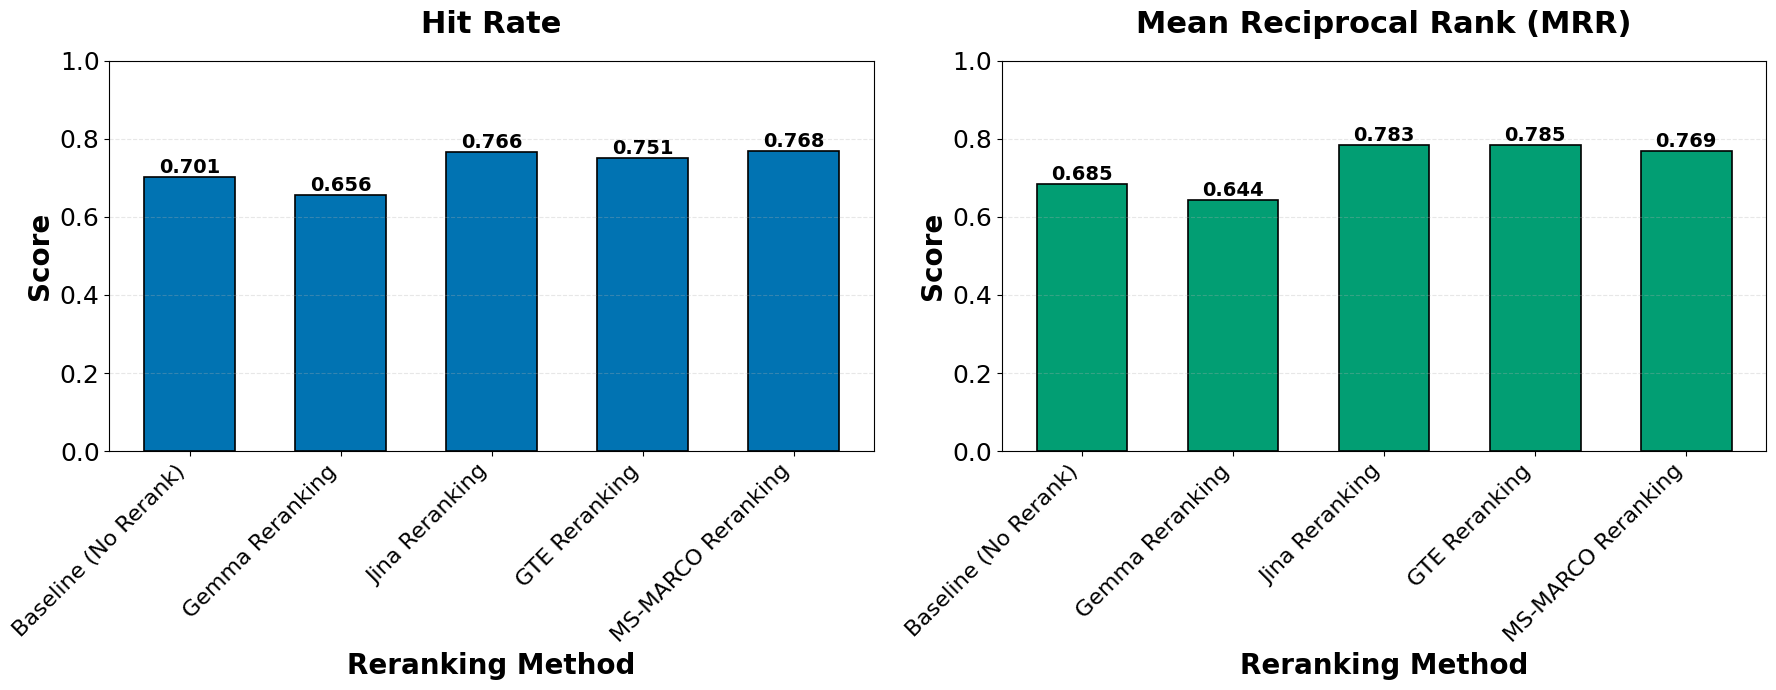

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", 5)

data = {
    'Baseline (No Rerank)': {'Hit Rate': 0.7012, 'MRR': 0.6850},
    'Gemma Reranking': {'Hit Rate': 0.6556, 'MRR': 0.6437},
    'Jina Reranking': {'Hit Rate': 0.7663, 'MRR': 0.7830},
    'GTE Reranking': {'Hit Rate': 0.7510, 'MRR': 0.7847},
    'MS-MARCO Reranking': {'Hit Rate': 0.7676, 'MRR': 0.7690},
}

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

methods = list(data.keys())
hit_rates = [data[m]['Hit Rate'] for m in methods]
mrrs = [data[m]['MRR'] for m in methods]

x = np.arange(len(methods))
width = 0.6

bars1 = axes[0].bar(x, hit_rates, width, color=colors[0], edgecolor='black', linewidth=1.2)
axes[0].set_ylabel('Score', fontsize=20, fontweight='bold')
axes[0].set_xlabel('Reranking Method', fontsize=20, fontweight='bold')
axes[0].set_title('Hit Rate', fontsize=22, fontweight='bold', pad=20)
axes[0].set_xticks(x)
axes[0].set_xticklabels(methods, rotation=45, ha='right', fontsize=16)
axes[0].tick_params(axis='y', labelsize=18)
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
# axes[0].axhline(y=0.7, color='gray', linestyle=':', alpha=0.5)

for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

bars2 = axes[1].bar(x, mrrs, width, color=colors[2], edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Score', fontsize=20, fontweight='bold')
axes[1].set_xlabel('Reranking Method', fontsize=20, fontweight='bold')
axes[1].set_title('Mean Reciprocal Rank (MRR)', fontsize=22, fontweight='bold', pad=20)
axes[1].set_xticks(x)
axes[1].set_xticklabels(methods, rotation=45, ha='right', fontsize=16)
axes[1].tick_params(axis='y', labelsize=18)
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
# axes[1].axhline(y=0.7, color='gray', linestyle=':', alpha=0.5)

for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('reranking_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
